# Requirements

In [1]:
!pip install tensorflow keras

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM
import numpy as np

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for Bitcoin. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- symbol - the resource for prediction
- open - the open price of BTC
- high - the high price of BTC
- low - the low price of BTC
- volumeBTC - the volume of trades BTC
- volumeUSD - the volume of trades USD
- close - the close price of BTC

Target:
close

Load the dataset into a `pandas` data frame.

In [87]:
data = pd.read_csv("./data/btc_daily.csv")
data.sample(5)

,date,symbol,open,high,low,close,Volume BTC,Volume USD
113,11/8/2021 0:00,BTC/USD,63300.00,67803.55,63300.00,67559.00,2.715424e+03,1.834513e+08
2117,5/14/2016 0:00,BTC/USD,456.42,457.25,453.51,455.38,6.128071e+05,1.344330e+03
1463,2/27/2018 0:00,BTC/USD,10324.70,10850.00,10150.00,10566.30,1.100868e+08,1.040848e+04
955,7/20/2019 0:00,BTC/USD,10533.71,11120.00,10359.17,10750.11,9.964674e+03,1.071213e+08
685,4/15/2020 0:00,BTC/USD,6868.88,6940.00,6598.55,6619.00,8.109732e+03,5.367832e+07


In [88]:
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.drop('symbol', axis=1)
df.set_index('date', inplace=True)

Explore the dataset using visualizations of your choice.

<Axes: >

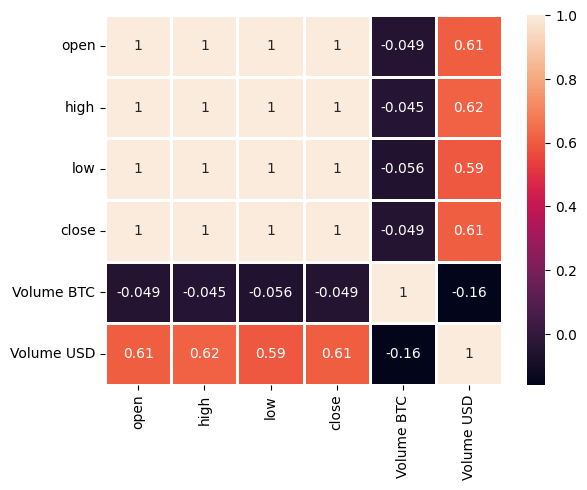

In [13]:
sns.heatmap(df.corr(), annot=True, linewidths=2)

# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [89]:
features  = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']

df.sort_index(inplace=True)

for lag in range(7,0,-1):
   for col in features:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()
df.head(5)

,open,high,low,close,Volume BTC,Volume USD,open_lag7,high_lag7,low_lag7,close_lag7,...,low_lag2,close_lag2,Volume BTC_lag2,Volume USD_lag2,open_lag1,high_lag1,low_lag1,close_lag1,Volume BTC_lag1,Volume USD_lag1
date,,,,,,,,,,,,,,,,,,,,,
2014-12-05,365.20,377.89,363.99,374.95,3331762.49,8951.16,363.59,381.34,360.57,376.28,...,374.23,376.67,2998357.92,7908.29,376.67,378.99,360.01,365.20,3297896.46,8865.09
2014-12-06,374.95,376.99,371.31,375.07,861748.71,2300.21,376.42,386.60,372.25,376.72,...,360.01,365.20,3297896.46,8865.09,365.20,377.89,363.99,374.95,3331762.49,8951.16
2014-12-07,375.07,377.50,373.16,376.87,913715.62,2429.62,376.57,381.99,373.32,373.34,...,363.99,374.95,3331762.49,8951.16,374.95,376.99,371.31,375.07,861748.71,2300.21
2014-12-08,376.87,377.45,364.60,364.61,3655238.40,9920.84,376.40,382.31,373.03,378.39,...,371.31,375.07,861748.71,2300.21,375.07,377.50,373.16,376.87,913715.62,2429.62
2014-12-09,364.61,365.48,343.97,350.49,7376463.45,20940.84,378.39,382.86,375.23,379.25,...,373.16,376.87,913715.62,2429.62,376.87,377.45,364.60,364.61,3655238.40,9920.84


In [90]:

df = df.drop(columns = ['open', 'high', 'low', 'Volume BTC', 'Volume USD'])
df.head()

,close,open_lag7,high_lag7,low_lag7,close_lag7,Volume BTC_lag7,Volume USD_lag7,open_lag6,high_lag6,low_lag6,...,low_lag2,close_lag2,Volume BTC_lag2,Volume USD_lag2,open_lag1,high_lag1,low_lag1,close_lag1,Volume BTC_lag1,Volume USD_lag1
date,,,,,,,,,,,,,,,,,,,,,
2014-12-05,374.95,363.59,381.34,360.57,376.28,3220878.18,8617.15,376.42,386.60,372.25,...,374.23,376.67,2998357.92,7908.29,376.67,378.99,360.01,365.20,3297896.46,8865.09
2014-12-06,375.07,376.42,386.60,372.25,376.72,2746157.05,7245.19,376.57,381.99,373.32,...,360.01,365.20,3297896.46,8865.09,365.20,377.89,363.99,374.95,3331762.49,8951.16
2014-12-07,376.87,376.57,381.99,373.32,373.34,1145566.61,3046.33,376.40,382.31,373.03,...,363.99,374.95,3331762.49,8951.16,374.95,376.99,371.31,375.07,861748.71,2300.21
2014-12-08,364.61,376.40,382.31,373.03,378.39,2520662.37,6660.56,378.39,382.86,375.23,...,371.31,375.07,861748.71,2300.21,375.07,377.50,373.16,376.87,913715.62,2429.62
2014-12-09,350.49,378.39,382.86,375.23,379.25,2593576.46,6832.53,379.25,383.00,374.23,...,373.16,376.87,913715.62,2429.62,376.87,377.45,364.60,364.61,3655238.40,9920.84


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [91]:
X, y = df.drop(columns=["close"]), df["close"]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [30]:
lag = 7

In [92]:
train_X.shape[0]

2115

In [112]:
train_X.shape[2]

42

In [94]:
(train_X.shape[0], lag, (train_X.shape[1] // lag)) 

(2115, 1, 42)

In [95]:

#train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))  # Shape: (samples, 1, features)
#test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1])) 

train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1] // lag))
test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1] // lag))


## Neural Networks

Create an LSTM model and train it using the `train` function.

In [96]:
model = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])), # (timesteps, features)
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

Use the trained model to make predictions for the test set.

In [97]:
# Write your code here. 

model.summary() 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1, 64)          │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,841 (155.63 KB)

 Trainable params: 39,841 (155.63 KB)

 Non-trainable params: 0 (0.00 B)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [104]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)
  

In [105]:
history = model.fit(train_X, train_y, validation_split=0.2, epochs=32, batch_size=5, shuffle=False)

Epoch 1/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 59608.4062 - mean_squared_error: 59608.4062 - val_loss: 217022.5312 - val_mean_squared_error: 217022.5312
Epoch 2/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 58632.4180 - mean_squared_error: 58632.4180 - val_loss: 217152.7188 - val_mean_squared_error: 217152.7188
Epoch 3/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56922.2148 - mean_squared_error: 56922.2109 - val_loss: 216513.5156 - val_mean_squared_error: 216513.5156
Epoch 4/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56441.9062 - mean_squared_error: 56441.9062 - val_loss: 215529.0781 - val_mean_squared_error: 215529.0781
Epoch 5/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56088.0781 - mean_squared_error: 56088.0781 - val_loss: 214467.6875 - val_mean_squared_error: 214467.7031
Epoch 6/32
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55781.0117 - mean_squared_error: 55781.0117 - val_loss: 213433.7031 - val_mean_squared_error: 213433.7031
Epoc

<Axes: >

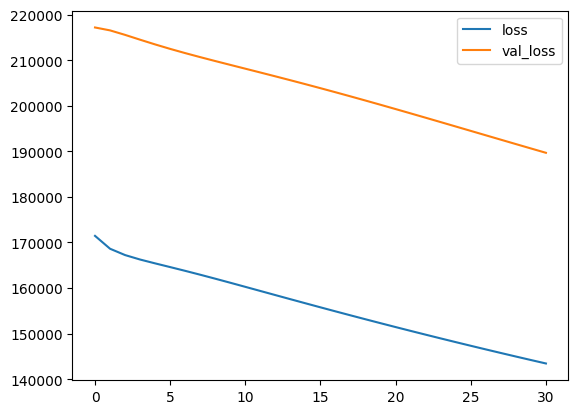

In [106]:
sns.lineplot(history.history['loss'][1:], label='loss')
sns.lineplot(history.history['val_loss'][1:], label='val_loss')


# Additional Bonus Task

Group the data by month. You can use [pandas.Grouper](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html) function.

Create an LSTM model to predict the 'close' price on a montly frequency.

In [107]:
pred_y = model.predict(test_X)
r2_score(test_y, pred_y)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


0.8453305728832654

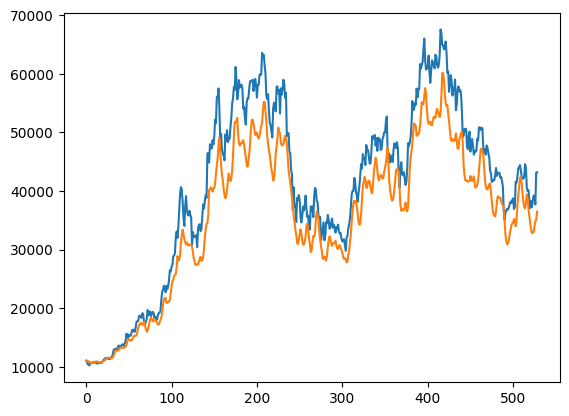

In [109]:
plt.plot(test_y.values)
plt.plot(pred_y)

In [117]:
df2 = df.copy()
df2 = df2.reset_index()
df2

,date,close,open_lag7,high_lag7,low_lag7,close_lag7,Volume BTC_lag7,Volume USD_lag7,open_lag6,high_lag6,...,low_lag2,close_lag2,Volume BTC_lag2,Volume USD_lag2,open_lag1,high_lag1,low_lag1,close_lag1,Volume BTC_lag1,Volume USD_lag1
0,2014-12-05,374.95,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03,376.42,386.60,...,374.23,376.67,2.998358e+06,7.908290e+03,376.67,378.99,360.01,365.20,3.297896e+06,8.865090e+03
1,2014-12-06,375.07,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03,376.57,381.99,...,360.01,365.20,3.297896e+06,8.865090e+03,365.20,377.89,363.99,374.95,3.331762e+06,8.951160e+03
2,2014-12-07,376.87,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03,376.40,382.31,...,363.99,374.95,3.331762e+06,8.951160e+03,374.95,376.99,371.31,375.07,8.617487e+05,2.300210e+03
3,2014-12-08,364.61,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03,378.39,382.86,...,371.31,375.07,8.617487e+05,2.300210e+03,375.07,377.50,373.16,376.87,9.137156e+05,2.429620e+03
4,2014-12-09,350.49,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03,379.25,383.00,...,373.16,376.87,9.137156e+05,2.429620e+03,376.87,377.45,364.60,364.61,3.655238e+06,9.920840e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,2022-02-25,39231.64,40532.66,40996.31,39450.00,39996.99,2.212715e+03,8.850194e+07,40008.75,40471.27,...,37060.16,37274.18,1.778275e+03,6.628375e+07,37253.26,39720.00,34324.05,38376.88,6.302851e+03,2.418838e+08
2640,2022-02-26,39146.66,40008.75,40471.27,39587.08,40109.02,6.956543e+02,2.790201e+07,40108.62,40151.62,...,34324.05,38376.88,6.302851e+03,2.418838e+08,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
2641,2022-02-27,37712.68,40108.62,40151.62,37974.18,38373.90,1.283512e+03,4.925334e+07,38384.09,39494.11,...,38027.61,39231.64,2.202852e+03,8.642149e+07,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2642,2022-02-28,43178.98,38384.09,39494.11,36810.72,37076.60,3.501420e+03,1.298208e+08,37036.98,38463.88,...,38600.00,39146.66,9.127241e+02,3.573010e+07,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07


In [118]:
df2 = df2.groupby(pd.Grouper(key='date', freq='ME')).mean().reset_index()
df2
#.last za month

,date,close,open_lag7,high_lag7,low_lag7,close_lag7,Volume BTC_lag7,Volume USD_lag7,open_lag6,high_lag6,...,low_lag2,close_lag2,Volume BTC_lag2,Volume USD_lag2,open_lag1,high_lag1,low_lag1,close_lag1,Volume BTC_lag1,Volume USD_lag1
0,2014-12-31,336.915185,353.362593,359.036667,346.214815,351.622222,3.054500e+06,8.841364e+03,351.782222,356.921481,...,335.597407,341.014444,2.943081e+06,8.711757e+03,341.050370,345.909630,333.218519,338.617037,2.946547e+06,8.785311e+03
1,2015-01-31,247.703871,266.782258,274.499032,256.492258,264.531290,4.273859e+06,1.861213e+04,264.494194,272.330323,...,244.095484,253.530000,5.298592e+06,2.279473e+04,253.502581,263.381290,241.426452,250.970645,5.348967e+06,2.311530e+04
2,2015-02-28,234.278214,234.787857,243.976071,226.010357,234.673929,3.314785e+06,1.364125e+04,234.624286,243.633929,...,225.560714,232.297500,2.004318e+06,8.625145e+03,232.281786,239.163571,225.878571,233.028214,2.034823e+06,8.703171e+03
3,2015-03-31,268.596774,267.534839,272.972903,260.442258,267.455806,2.354446e+06,8.768249e+03,267.583871,273.056129,...,261.820323,269.060323,2.536396e+06,9.481832e+03,269.157742,274.445484,261.831935,268.887097,2.420980e+06,9.025816e+03
4,2015-04-30,234.833333,239.966667,243.622333,234.814667,239.573667,1.896146e+06,7.979160e+03,239.573667,243.155667,...,231.284333,235.847667,1.926445e+06,8.247804e+03,235.847667,239.309333,230.794000,235.107667,1.927029e+06,8.273855e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2021-11-30,60705.494000,61850.626333,63152.651000,60134.717333,61744.982000,2.445235e+03,1.497771e+08,61740.624667,62953.193333,...,59409.581000,60987.910667,2.321960e+03,1.403298e+08,60982.897667,62212.798000,59279.247000,60851.671333,2.339540e+03,1.411366e+08
84,2021-12-31,49328.349032,51397.258710,52649.493871,49613.374516,51184.920645,2.498509e+03,1.277716e+08,51180.275161,52437.531290,...,48648.977097,50020.418710,2.373162e+03,1.191665e+08,50019.862903,51138.701290,48300.085806,49675.437742,2.376147e+03,1.185932e+08
85,2022-01-31,41111.849677,44013.662903,44821.180645,42591.720000,43562.009032,2.164121e+03,9.043561e+07,43557.668387,44381.598065,...,40575.126452,41658.021935,2.358715e+03,9.505322e+07,41648.404516,42483.375161,40298.940000,41360.960968,2.311829e+03,9.263194e+07
86,2022-02-28,40763.182143,40402.154643,41348.741429,39383.839286,40413.088571,1.983289e+03,7.964528e+07,40413.418571,41381.297857,...,39504.056429,40603.970714,1.994261e+03,8.061420e+07,40605.327143,41653.778571,39491.311786,40595.787143,2.029727e+03,8.194588e+07


In [119]:
df2.set_index('date', inplace=True)
df2

,close,open_lag7,high_lag7,low_lag7,close_lag7,Volume BTC_lag7,Volume USD_lag7,open_lag6,high_lag6,low_lag6,...,low_lag2,close_lag2,Volume BTC_lag2,Volume USD_lag2,open_lag1,high_lag1,low_lag1,close_lag1,Volume BTC_lag1,Volume USD_lag1
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,336.915185,353.362593,359.036667,346.214815,351.622222,3.054500e+06,8.841364e+03,351.782222,356.921481,344.587407,...,335.597407,341.014444,2.943081e+06,8.711757e+03,341.050370,345.909630,333.218519,338.617037,2.946547e+06,8.785311e+03
2015-01-31,247.703871,266.782258,274.499032,256.492258,264.531290,4.273859e+06,1.861213e+04,264.494194,272.330323,254.063226,...,244.095484,253.530000,5.298592e+06,2.279473e+04,253.502581,263.381290,241.426452,250.970645,5.348967e+06,2.311530e+04
2015-02-28,234.278214,234.787857,243.976071,226.010357,234.673929,3.314785e+06,1.364125e+04,234.624286,243.633929,225.694286,...,225.560714,232.297500,2.004318e+06,8.625145e+03,232.281786,239.163571,225.878571,233.028214,2.034823e+06,8.703171e+03
2015-03-31,268.596774,267.534839,272.972903,260.442258,267.455806,2.354446e+06,8.768249e+03,267.583871,273.056129,260.568710,...,261.820323,269.060323,2.536396e+06,9.481832e+03,269.157742,274.445484,261.831935,268.887097,2.420980e+06,9.025816e+03
2015-04-30,234.833333,239.966667,243.622333,234.814667,239.573667,1.896146e+06,7.979160e+03,239.573667,243.155667,234.534667,...,231.284333,235.847667,1.926445e+06,8.247804e+03,235.847667,239.309333,230.794000,235.107667,1.927029e+06,8.273855e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,60705.494000,61850.626333,63152.651000,60134.717333,61744.982000,2.445235e+03,1.497771e+08,61740.624667,62953.193333,59975.538000,...,59409.581000,60987.910667,2.321960e+03,1.403298e+08,60982.897667,62212.798000,59279.247000,60851.671333,2.339540e+03,1.411366e+08
2021-12-31,49328.349032,51397.258710,52649.493871,49613.374516,51184.920645,2.498509e+03,1.277716e+08,51180.275161,52437.531290,49429.383548,...,48648.977097,50020.418710,2.373162e+03,1.191665e+08,50019.862903,51138.701290,48300.085806,49675.437742,2.376147e+03,1.185932e+08
2022-01-31,41111.849677,44013.662903,44821.180645,42591.720000,43562.009032,2.164121e+03,9.043561e+07,43557.668387,44381.598065,42124.995161,...,40575.126452,41658.021935,2.358715e+03,9.505322e+07,41648.404516,42483.375161,40298.940000,41360.960968,2.311829e+03,9.263194e+07


In [120]:
X, y = df2.drop(columns=["close"]), df2["close"]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [121]:
train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1] // lag))
test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1] // lag))

In [122]:
model2 = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])), # (timesteps, features)
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

In [128]:
model2.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [145]:
history = model2.fit(train_X, train_y, validation_split=0.2, epochs=32, batch_size=3, shuffle=False)

Epoch 1/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26982.4043 - mean_squared_error: 26982.4043 - val_loss: 199532.6094 - val_mean_squared_error: 199532.6094
Epoch 2/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26752.0137 - mean_squared_error: 26752.0137 - val_loss: 199790.9531 - val_mean_squared_error: 199790.9531
Epoch 3/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26525.2734 - mean_squared_error: 26525.2734 - val_loss: 200053.4062 - val_mean_squared_error: 200053.4062
Epoch 4/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26302.1211 - mean_squared_error: 26302.1211 - val_loss: 200321.2344 - val_mean_squared_error: 200321.2344
Epoch 5/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26082.5293 - mean_squared_error: 26082.5293 - val_loss: 200592.4531 - val_mean_squared_error: 200592.4531
Epoch 6/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25866.5195 - mean_squared_error: 25866.5195 - val_loss: 200868.2812 - val_mean_squared_error: 200868.2812
Epoch 7/32
19/19

<Axes: >

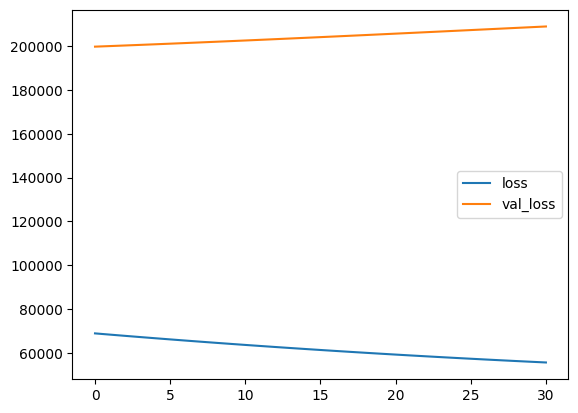

In [146]:
sns.lineplot(history.history['loss'][1:], label='loss')
sns.lineplot(history.history['val_loss'][1:], label='val_loss')

In [147]:
pred_y_bonus = model2.predict(test_X)
r2_score(test_y, pred_y_bonus)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


0.844847729477349

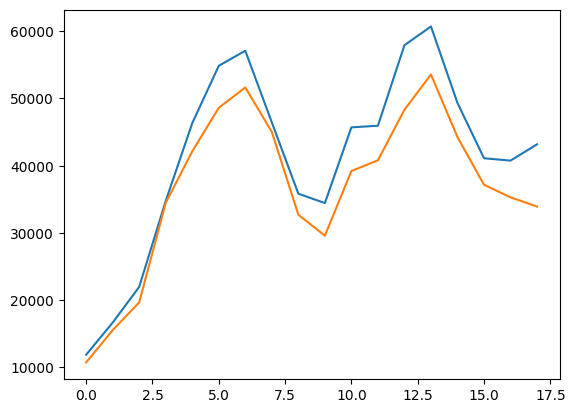

In [148]:
plt.plot(test_y.values)
plt.plot(pred_y_bonus)